<a href="https://colab.research.google.com/github/veronicasage/vse97_coding1/blob/main/coding1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To collect this data, I used the BeautifulSoup API package to scrape data from the Wikipedia page "List of Municipalities in Texas" and store it in a dictionary. The code segment below outputs the raw data.

In [ ]:
import pandas as pd # data analysis library
import requests # request library
from bs4 import BeautifulSoup # scraping / parsing library
import scipy
from matplotlib import pyplot as plt

# get the article's html
url = "https://en.wikipedia.org/wiki/List_of_municipalities_in_Texas"
table_class="wikitable sortable jquery-tablesorter" #define table category
html = requests.get(url)

print(html.status_code) #check to ensure site scraping is allowed (200 means yes)

# initialize beautifulsoup object from html data
soup = BeautifulSoup(html.text, 'html.parser')
table=soup.find('table',{'class':"wikitable"})

#create empty list for storing raw data
raw_data = []

# iterate over table rows to add to raw data
for row in table.find_all('tr'):
    cells = row.find_all('td')
    if cells:  # check if the row is not empty
        line = [cell.text.strip() for cell in cells]
        raw_data.append(line)

print(raw_data)


200
[['1', 'Houston', 'City', 'Harris', 'Fort Bend, Montgomery', '2,302,878', '2,304,580', '2,099,451', '+9.77%'], ['2', 'San Antonio', 'City', 'Bexar', 'Medina, Comal', '1,472,909', '1,434,625', '1,327,407', '+8.08%'], ['3', 'Dallas', 'City', 'Dallas', 'Rockwall, Kaufman, Denton, Collin', '1,299,544', '1,304,379', '1,197,816', '+8.90%'], ['4', 'Austin', 'City', 'Travis', 'Williamson, Hays', '974,447', '961,855', '790,390', '+21.69%'], ['5', 'Fort Worth', 'City', 'Tarrant', 'Denton, Parker, Wise', '956,709', '918,915', '741,206', '+23.98%'], ['6', 'El Paso', 'City', 'El Paso', '', '677,456', '678,815', '649,121', '+4.57%'], ['7', 'Arlington', 'City', 'Tarrant', '', '394,602', '392,786', '365,438', '+7.48%'], ['8', 'Corpus Christi', 'City', 'Nueces', 'San Patricio, Aransas, Kleberg', '316,239', '317,863', '305,215', '+4.14%'], ['9', 'Plano', 'City', 'Collin', 'Denton', '289,547', '285,494', '259,841', '+9.87%'], ['10', 'Lubbock', 'City', 'Lubbock', '', '263,930', '257,141', '229,573', '

I used the Pandas package to create a dataframe from the raw values, and transformed the data by removing unnecesary (not used in analysis / uninformative) columns, all municipalities categorized as towns rather than cities, and all remaining entries after the top 200 ranked cities. I also removed non-numerical characters for all "population" and "change" entries to allow for their conversion from strings to floats so that calculations could be performed.

In [ ]:
# define column names
column_names = ["Rank", "City", "Designation", "Primary County", "Secondary county(ies)", "Population", "2020 Census", "2010 Census", "2010-2020 Change"]

# intialize list to organize data
final_data = []

# iterate over the raw data to construct a list of dictionaries
for row in raw_data:
    if len(row) == len(column_names):
        entry = dict(zip(column_names, row))
        final_data.append(entry)

# create dataframe from the list of dictionaries
final_data = pd.DataFrame(final_data)

# drop unwanted columns, rows, and towns
final_data = final_data[final_data["Designation"] != "Town"]
final_data = final_data.drop(["Designation", "Secondary county(ies)", "2020 Census", "2010 Census",], axis=1)
final_data.drop(final_data.index[196:992], inplace=True)

# define function to clean and reformat data
def clean_string(s):
    s = s.replace(",","")
    s = s.replace("%","")
    s = s.replace("+","")
    if "−" in s or "-" in s:
      s = s.replace("−", "0")
      s = s.replace("-", "0")
      s = float(s)
      s = s * -1
    s = float(s)
    return s

#apply cleaning function
final_data["Population"] = final_data["Population"].apply(clean_string)
final_data["2010-2020 Change"] = final_data["2010-2020 Change"].apply(clean_string)

final_data.to_csv('data.csv')

#print the first few rows of the dataframe
final_data

,Rank,City,Primary County,Population,2010-2020 Change
0,1,Houston,Harris,2302878.0,9.77
1,2,San Antonio,Bexar,1472909.0,8.08
2,3,Dallas,Dallas,1299544.0,8.90
3,4,Austin,Travis,974447.0,21.69
4,5,Fort Worth,Tarrant,956709.0,23.98
...,...,...,...,...,...
194,195,Jacksonville,Cherokee,14215.0,-3.76
195,196,Dumas,Moore,14166.0,-1.29
196,197,Lumberton,Hardin,14045.0,13.49
197,198,Azle,Tarrant,13956.0,22.12


In looking over this data, I was curious what relationship might exist between

After looking at the cleaned data, I was curious what relationship might exist between population size and change, so I calculated basic descriptive statistics about each category and used the SciPy package to calculate the statistical correlation between the two.

In [ ]:
from scipy.stats import pearsonr

#create lists from columns used for graph
population = final_data["Population"]
change = final_data["2010-2020 Change"]

#calculate basic stats about the data
print(population.describe())
print(change.describe())
p = pearsonr(population, change)
print (p[0])

count    1.960000e+02
mean     9.660351e+04
std      2.384104e+05
min      1.370800e+04
25%      1.960725e+04
50%      3.440350e+04
75%      8.076700e+04
max      2.302878e+06
Name: Population, dtype: float64
count     196.000000
mean       31.322551
std       103.703302
min       -11.720000
25%         6.395000
50%        12.255000
75%        25.837500
max      1386.420000
Name: 2010-2020 Change, dtype: float64
-0.04317418100093909


Using a linear regression models to analyze the relationship between population size and change reveals that there is only a very slight, statiscally insignificant (n < .1) correlation between the two variables, indicating that the change in a city's population cannot be predicted from its size. Below I created a scatterplot using MatPlotLib tools to visualize this.

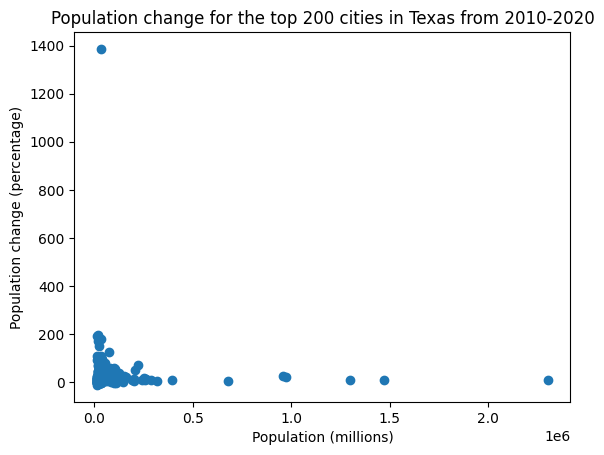

In [20]:
#create and format scatterplot
plt.scatter(population, change)
plt.title("Population change for the top 200 cities in Texas from 2010-2020")
plt.xlabel("Population (millions)")
plt.ylabel("Population change (percentage)")
plt.savefig("coding1_plot.jpg")

# New Section

# New Section